# 1) Load dependencies, set session parameters, and load the MNIST data

The main point of this basic notebook is to compare classical ML models (SVM, Random Forest, Bayesian) to basic neural network architectures (MLP and CNN). We will look at an incredibly simple image set of 28X28 pixel greyscale images from the MNIST dataset. This is a nice place to start getting comfortable with ML, PyTorch training/testing/evaluation/interpretation without getting bogged down in complex datasets or more advance deep learning frameworks

In [1]:
## Basic PyTorch functionality
import torch
from torch import nn
from torch.utils.data import DataLoader

## CPU data structures
import pandas as pd

## Public datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

## Classical ML-frameworks
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## Plotting
import matplotlib.pyplot as plt

## Custom modules
import jm_pytorch_tutorials as jpt
from jm_pytorch_tutorials.models import MLP, CNN, SklearnModelWrapper

In [2]:
# Hyperparameters for session
batch_size = 64
device = jpt.utils.get_device()
print(f"Using device: {device}")

Using device: mps


In [3]:
# Dataset downloading, normalization, adding to train/test splits
download = False
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(root="./data", train=True, transform=transform, download=download)
test_dataset = MNIST(root="./data", train=False, transform=transform, download=download)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

X_test_tensor = torch.stack([x[0] for x in test_dataset]).to(device)

# 2) Training/Testing PyTorch and Sklearn models

In [4]:
## PyTorch Train/Test

# Instantiate Pytorch models
torch_models = {
    "MLP": MLP(input_shape=(1, 28, 28), hidden_dims=[512], num_classes=10),
    "CNN": CNN(input_shape=(1, 28, 28), conv_channels=[32, 64], fc_dims=[128], num_classes=10),
}

# Loop through to train/test all Pytorch models
for name, model in torch_models.items():
    # Train each Pytorch model instance
    jpt.train.train_torch_model(model, train_loader, epochs=3,
                optimizer_class=torch.optim.Adam,
                learning_rate=0.001,
                criterion=nn.CrossEntropyLoss())
    # Evaluate each trained Pytorch model on a test dataset
    print(f"Testing {name}")
    jpt.test.evaluate_torch_model(model, test_loader, 
                                  class_names=None, save_to_model=True)

Training model: MLP
Trainable parameters: 407,050
Epoch 1/3: Loss = 243.7765 | Time = 2.35s
Epoch 2/3: Loss = 94.0045 | Time = 2.31s
Epoch 3/3: Loss = 61.0298 | Time = 2.30s
Total training time: 6.96s
Testing MLP
Evaluating model: MLP

Evaluation Accuracy: 97.41% | Time: 0.33s
Per-Class ROC AUC and PR AUC:
  class_0: ROC AUC = 1.000, PR AUC = 0.999
  class_1: ROC AUC = 1.000, PR AUC = 0.999
  class_2: ROC AUC = 1.000, PR AUC = 0.996
  class_3: ROC AUC = 0.999, PR AUC = 0.996
  class_4: ROC AUC = 1.000, PR AUC = 0.997
  class_5: ROC AUC = 1.000, PR AUC = 0.997
  class_6: ROC AUC = 1.000, PR AUC = 0.998
  class_7: ROC AUC = 1.000, PR AUC = 0.996
  class_8: ROC AUC = 0.999, PR AUC = 0.995
  class_9: ROC AUC = 0.999, PR AUC = 0.995

Macro ROC AUC: 1.000 | Macro PR AUC: 0.997
Training model: CNN
Trainable parameters: 421,642
Epoch 1/3: Loss = 158.6646 | Time = 5.83s
Epoch 2/3: Loss = 47.5487 | Time = 5.80s
Epoch 3/3: Loss = 32.1298 | Time = 5.98s
Total training time: 17.61s
Testing CNN
Eval

In [5]:
## Sklearn Fit/Eval

# Flatten images and move to CPU
X_train = train_dataset.data.view(-1, 28*28).numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.view(-1, 28*28).numpy()
y_test = test_dataset.targets.numpy()

# Subsample to speed up training
X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

# Instantiate wrapped Sklearn models
sklearn_models = {
    "SVM": SklearnModelWrapper(SVC(kernel='linear', probability=True)),
    "RF": SklearnModelWrapper(RandomForestClassifier(n_estimators=100, n_jobs=-1)),
    "NB": SklearnModelWrapper(GaussianNB())
}

# Loop through Sklearn models to fit/eval
for name, model in sklearn_models.items():
    model.fit(X_train_small, y_train_small)
    metrics = model.evaluate(X_test, y_test)

Training SVC
Training time: 8.67s
Evaluating SVC
Evaluating model: SVC
Training RandomForestClassifier
Training time: 0.26s
Evaluating RandomForestClassifier
Evaluating model: RandomForestClassifier
Training GaussianNB
Training time: 0.04s
Evaluating GaussianNB
Evaluating model: GaussianNB


# 3) Organizing/visualizing eval metrics

In [6]:
## Consolidate models and evaluation metrics
all_models = {** sklearn_models, **torch_models}
results = []

for name, model in all_models.items():
    results.append(model.eval_metrics)

In [7]:
## Structure results into a DataFrame if you'd like
df = pd.DataFrame([{
    "Model": r["label"],
    "Accuracy": r["accuracy"],
    "AUROC": r["auroc"],
    "AUPRC": r["auprc"],
    "Train Time (s)": r["train_time"],
    "Inference Time (s)": r["inference_time"]
} for r in results])
print(df.round(4))

                    Model  Accuracy   AUROC   AUPRC  Train Time (s)  \
0                     SVC    0.9201  0.9943  0.9671          8.6719   
1  RandomForestClassifier    0.9488  0.9973  0.9833          0.2554   
2              GaussianNB    0.5738  0.9179  0.6094          0.0357   
3                     MLP   97.4100  0.9996  0.9969          6.9550   
4                     CNN   98.8200  0.9999  0.9995         17.6090   

   Inference Time (s)  
0              2.7159  
1              0.0337  
2              0.1308  
3              0.3268  
4              0.4292  


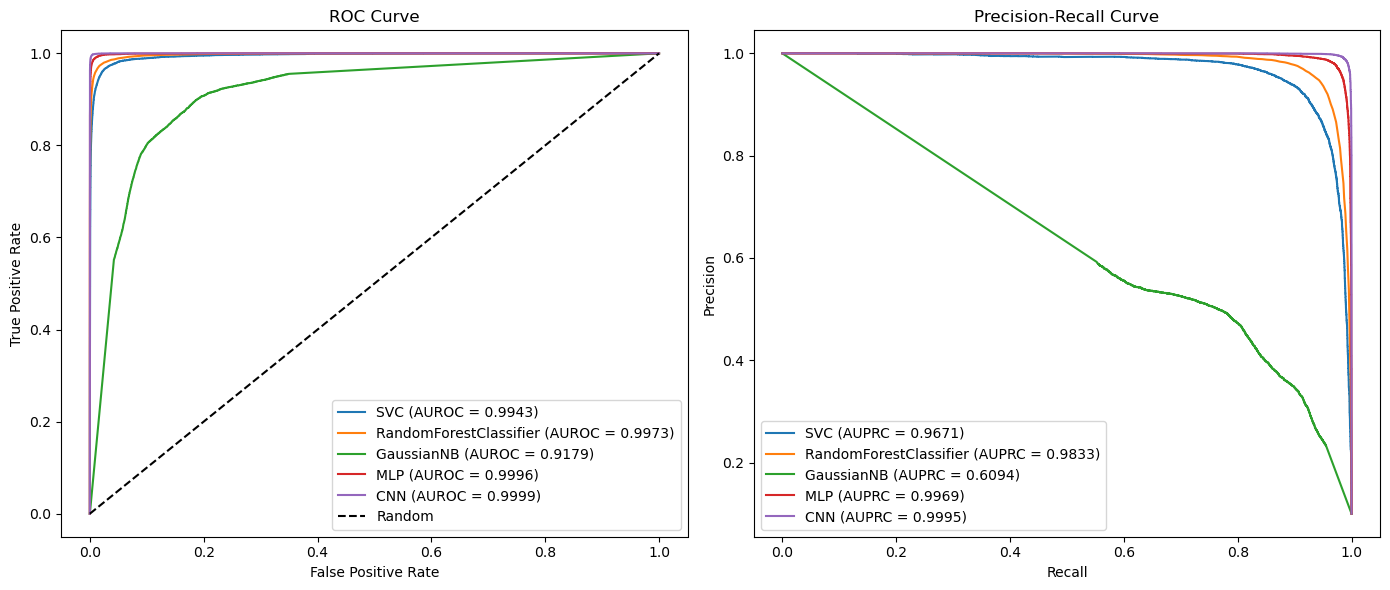

In [8]:
## Plot ROC and P/R curves
jpt.plot_roc_pr_curves(results)

# 4) Model interpretability

In [9]:
# Pick a test image for passing through the model
x, y = test_dataset[0]

Feature saliency for MLP


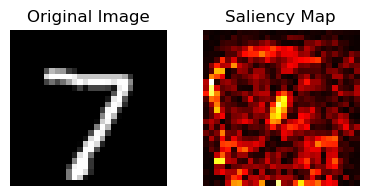

Feature saliency for CNN


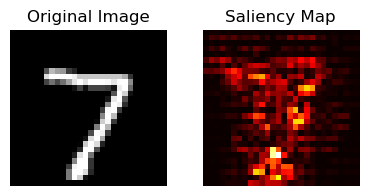

In [10]:
## PyTorch models - input feature saliency
for name, model in torch_models.items():
    print(f"Feature saliency for {name}")
    sal = jpt.compute_saliency(model, x, y)
    jpt.show_saliency_map(x, sal)

In [11]:
## Look at the structure of the CNN model class
cnn = torch_models['CNN']
cnn

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)

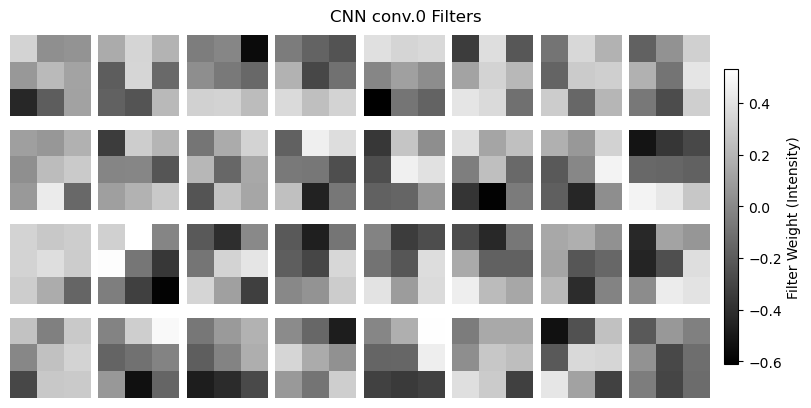

In [12]:
## Visualize the learned filters from the first convolutional layer of the CNN
layer_name = "conv.0"
layer = dict(cnn.named_modules()).get(layer_name, None)

weights = jpt.get_conv_filters(layer)
jpt.plot_conv_filters(weights, title=f"CNN {layer_name} Filters")


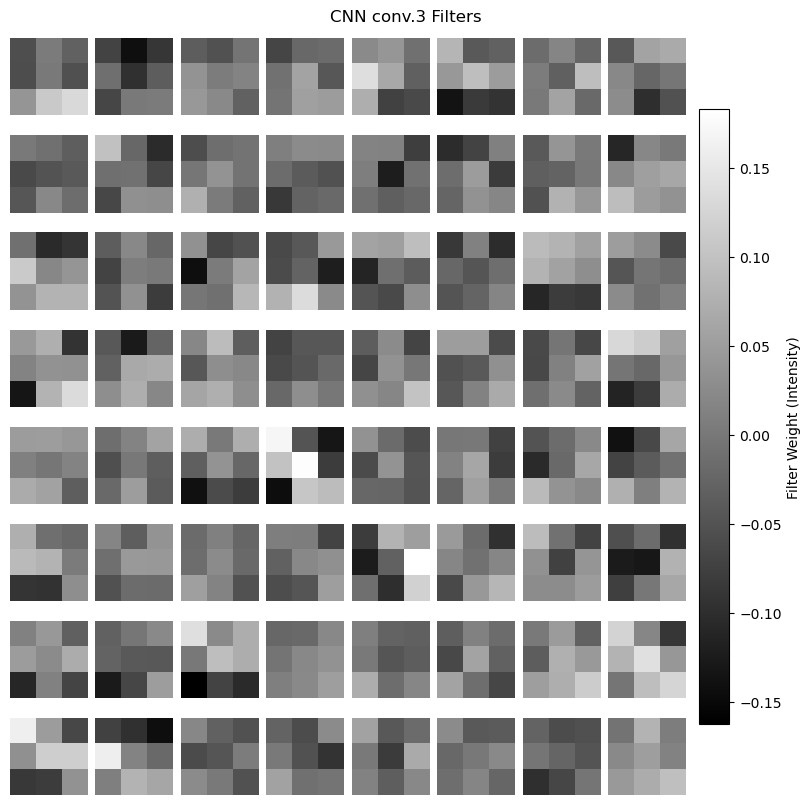

In [13]:
# Plot filters from second convolutional layer
layer_name = "conv.3"
layer = dict(cnn.named_modules()).get(layer_name, None)

weights = jpt.get_conv_filters(layer)
jpt.plot_conv_filters(weights, title=f"CNN {layer_name} Filters")

In [14]:
# Choose a test image to use for visualizing convolutions, activation patterns, and classification logits
img, label = test_dataset[0]

Note: To us, it is obvious that the input image represents a digit. In the feature maps within the convolutions/activations/pools, it may be seem obvious that the digit still looks to be interpretable. So why are these learned representations a big deal? What if the image came from a biological sample with known properties that are not obvious in the input image? CNNs can learn features/representations that are predictive of these properties in non-trivial ways.

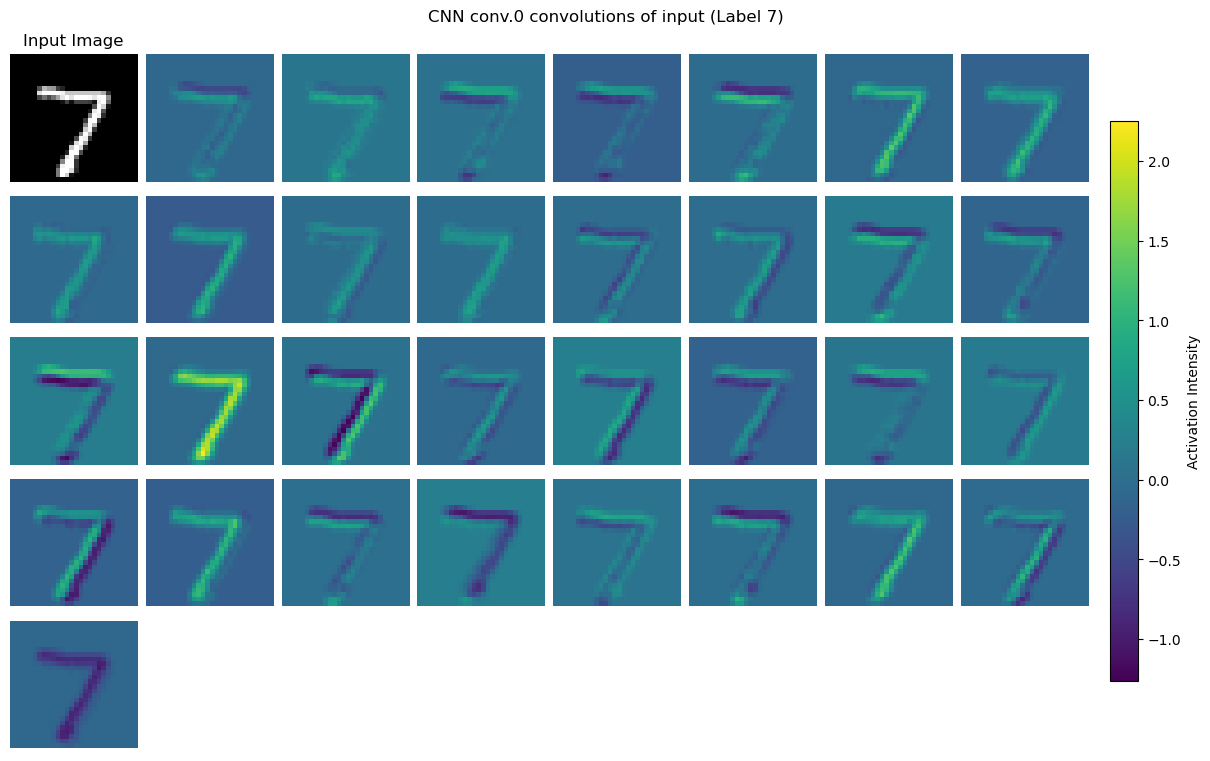

In [15]:
## Visualize the convolutions from the learned filters of the first convolutional layer
layer_name='conv.0'

# Get convolutions
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + convolutions
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} convolutions of input (Label {label})")

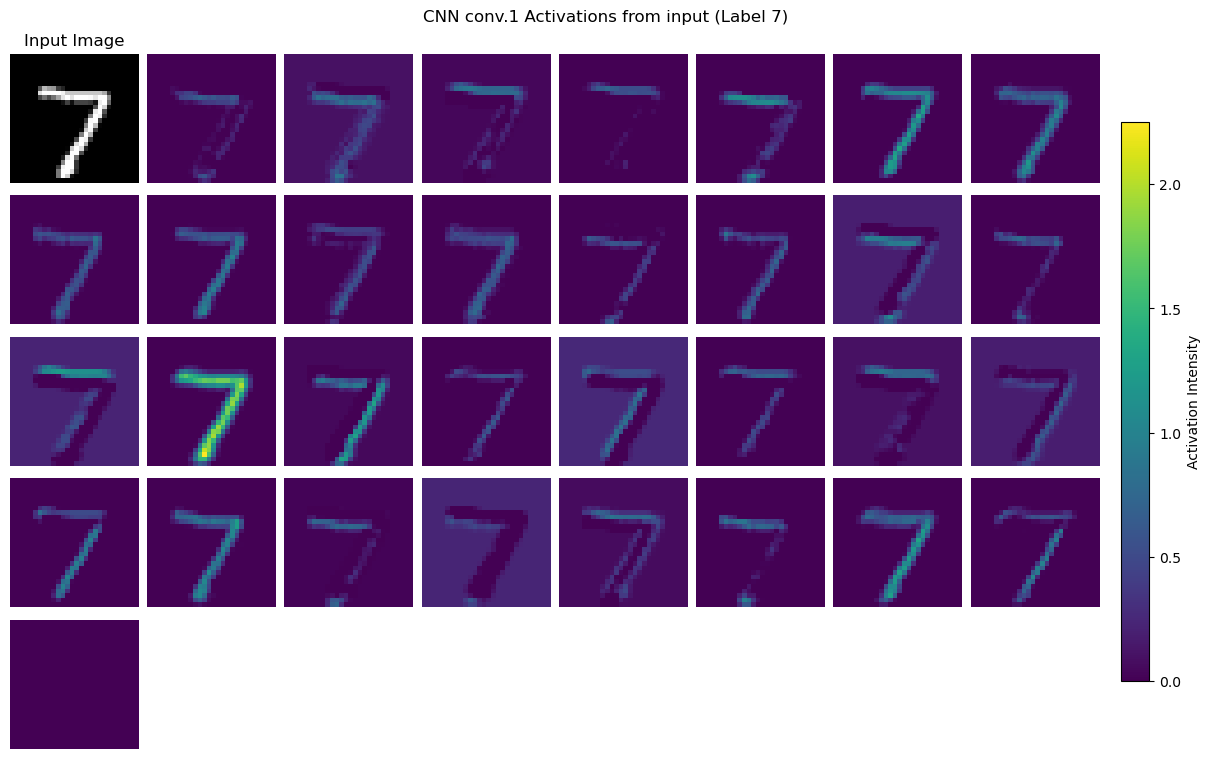

In [16]:
## Visualize the activation patterns from the convolutions

layer_name='conv.1'

# Get activations
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + activations
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} Activations from input (Label {label})")

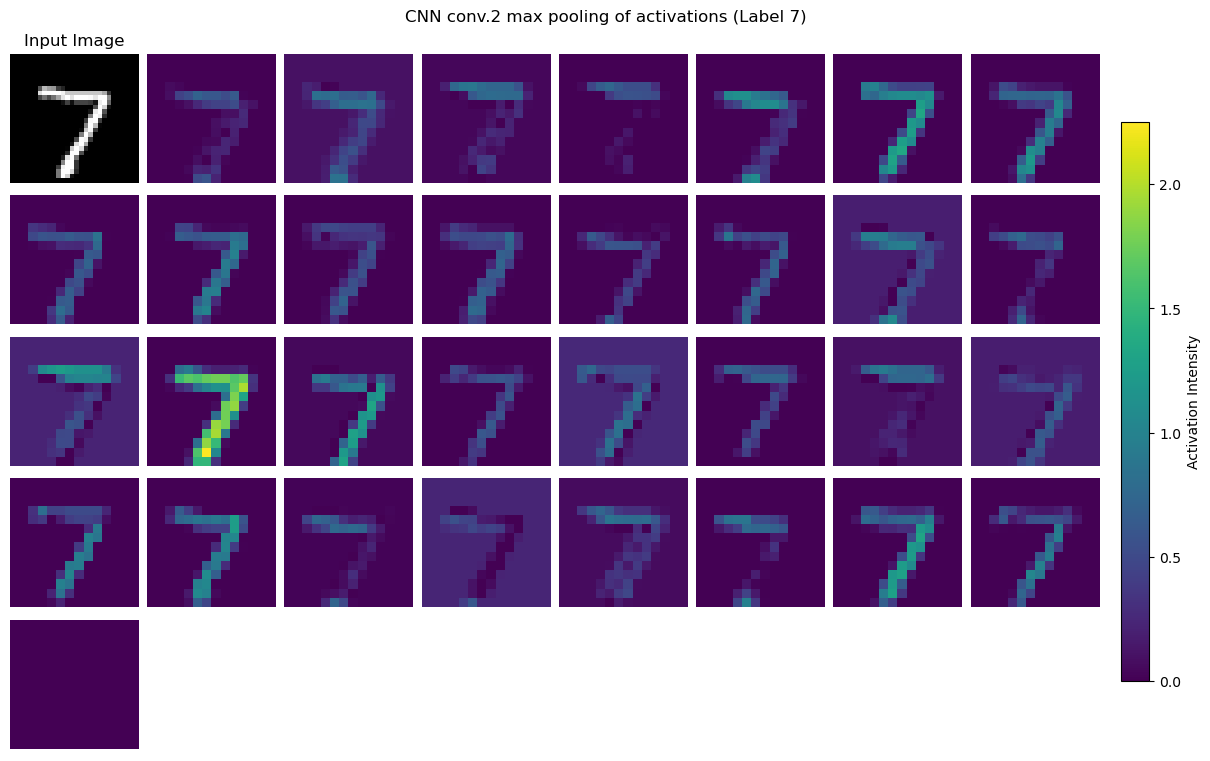

In [17]:
## Visualize the max pooling of activations

layer_name='conv.2'

# Get max pooled features
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + max pooled downsampling
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} max pooling of activations (Label {label})")

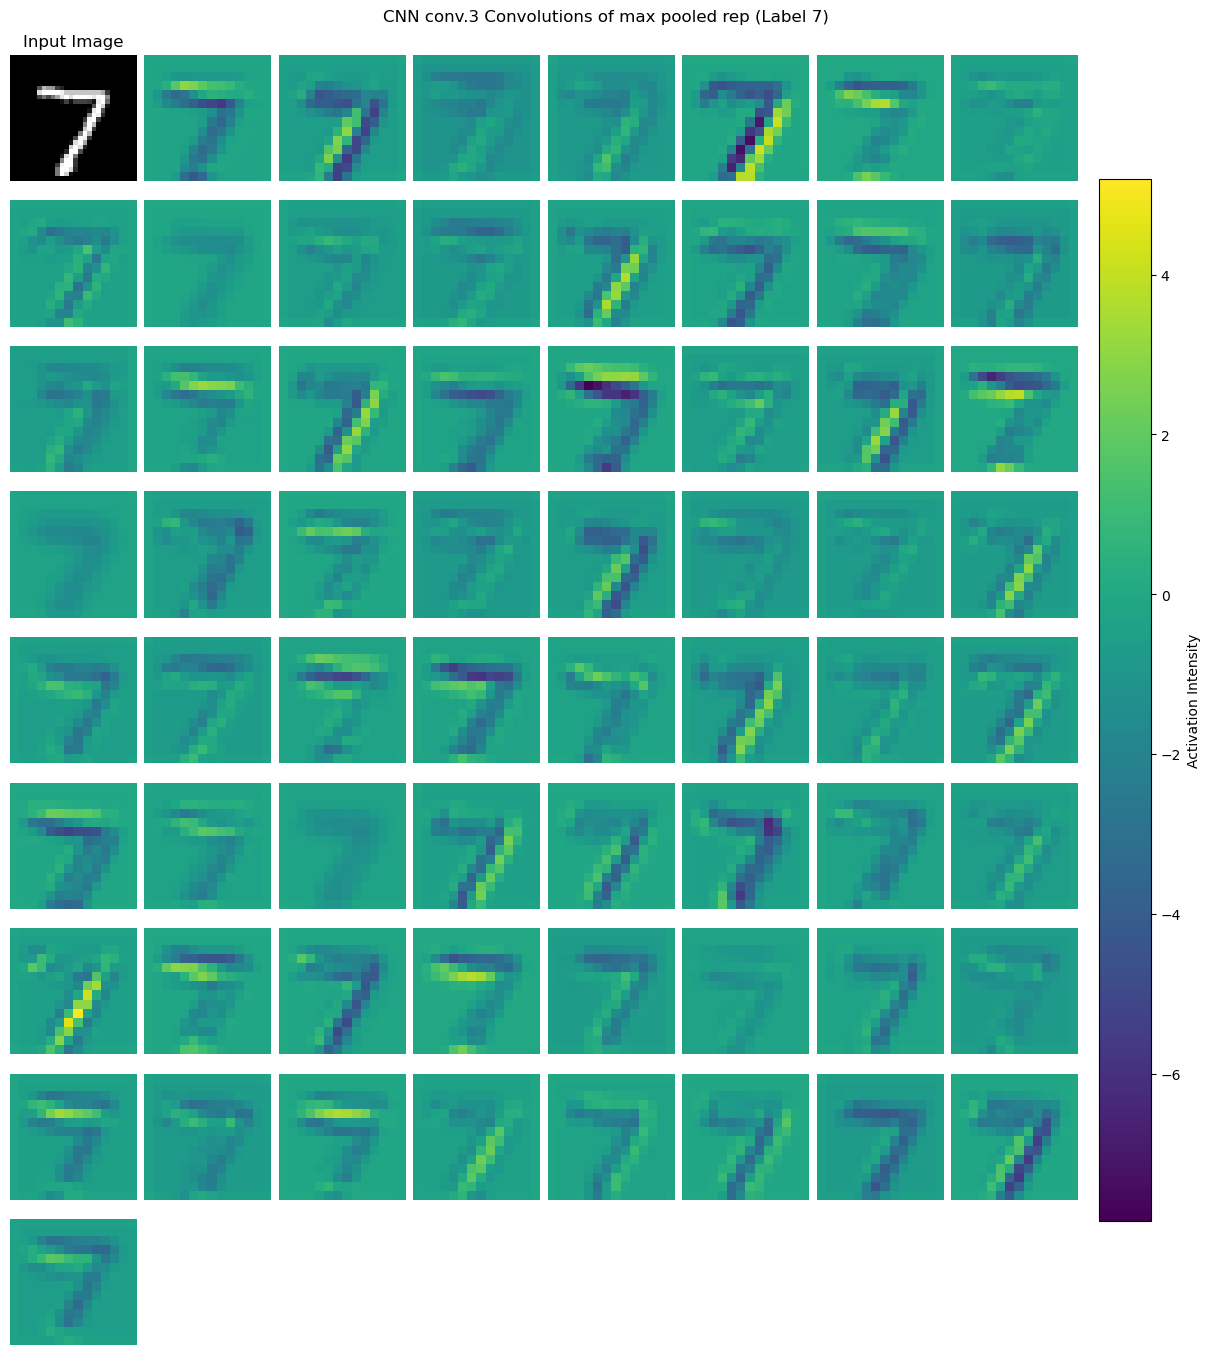

In [18]:
## Visualize the second convolution.

layer_name='conv.3'

# Get activations
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + convolution
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} Convolutions of max pooled rep (Label {label})")

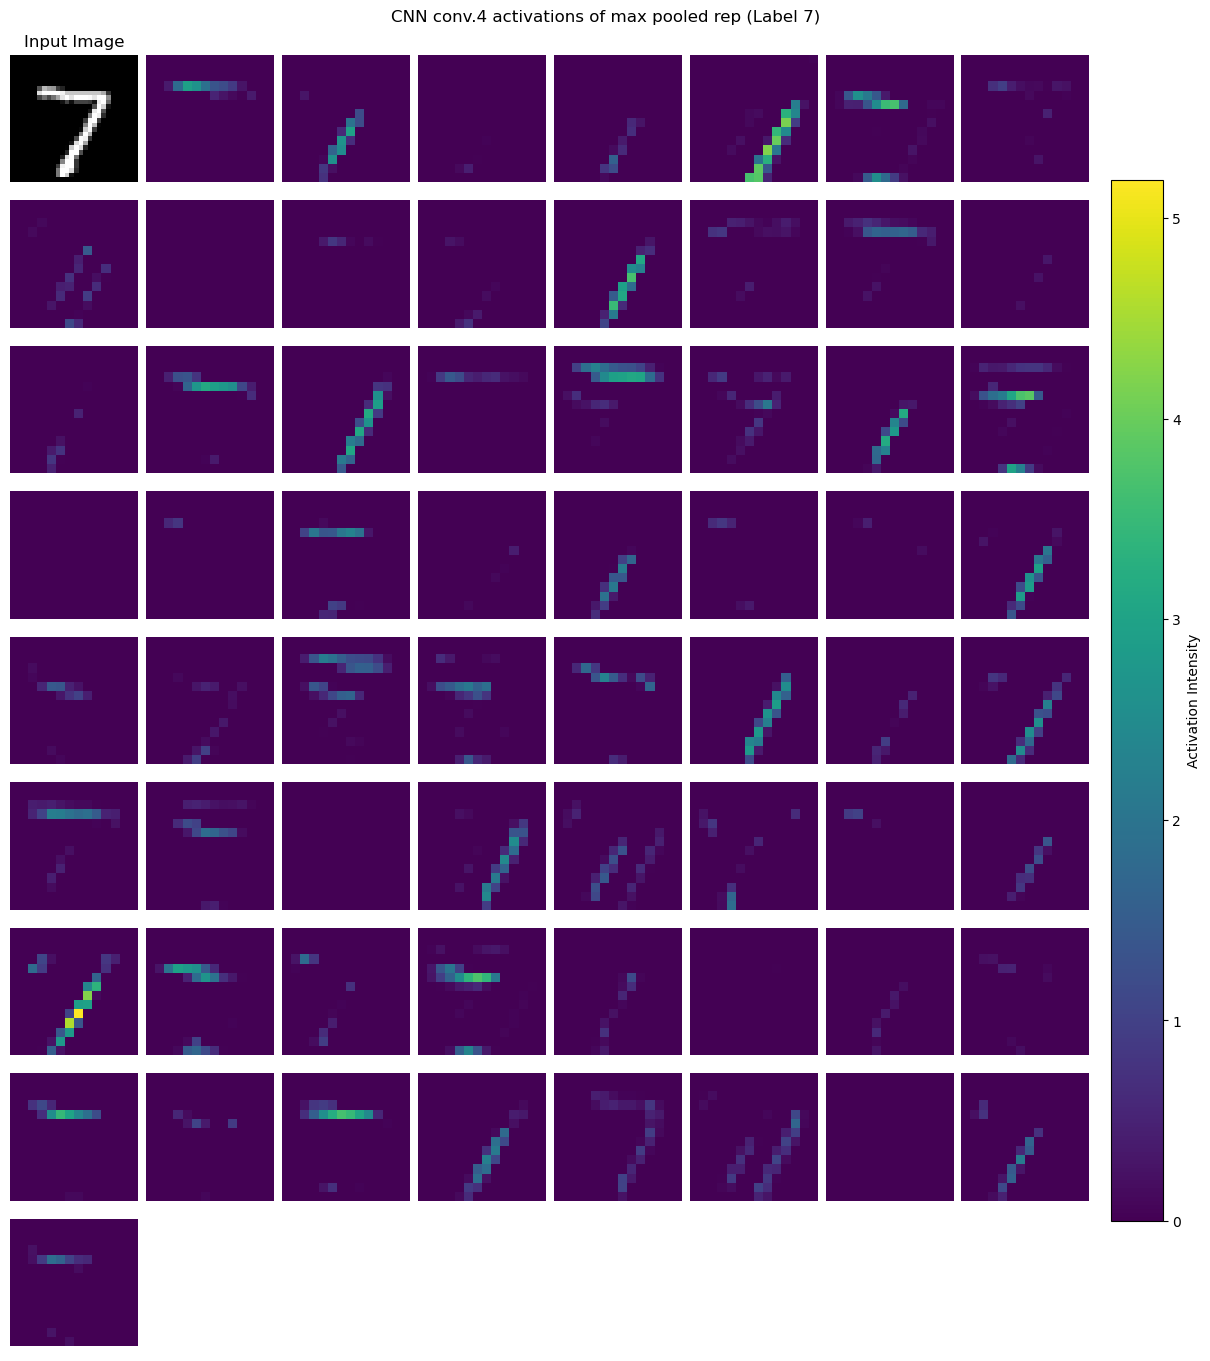

In [19]:
## Visualize the activation patterns from the second convolutional layer

layer_name='conv.4'

# Get convolutions
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + activations
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} activations of max pooled rep (Label {label})")

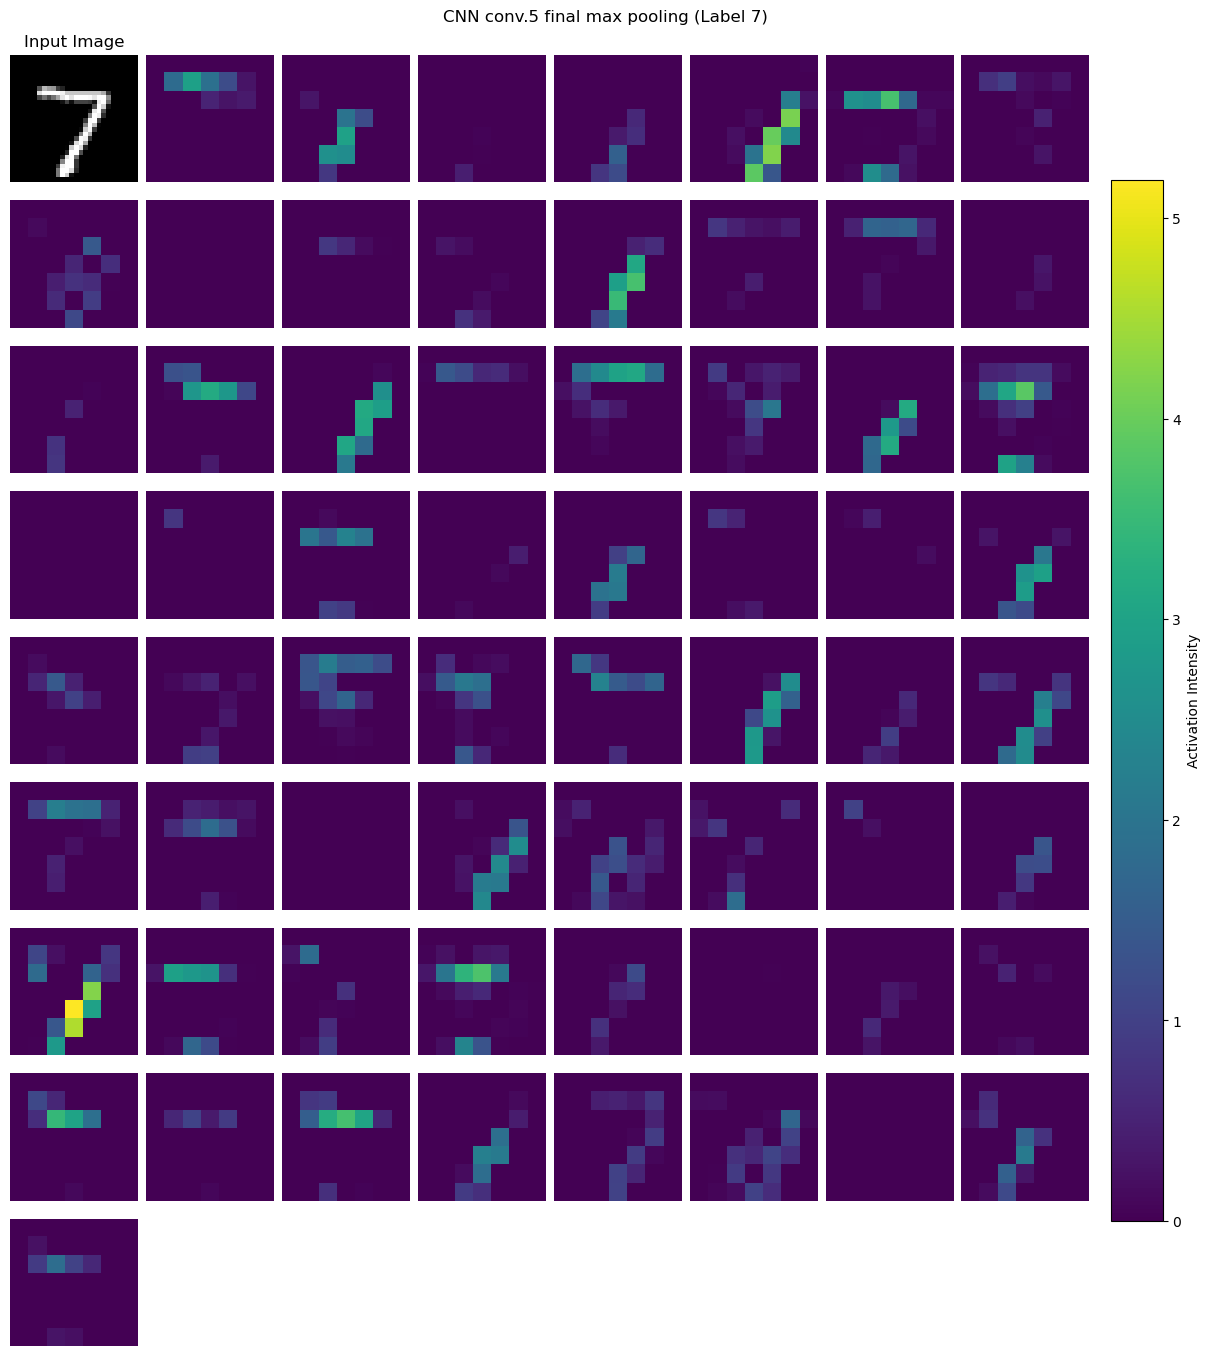

In [20]:
## Visualize the final max pooling

layer_name='conv.5'

# Get final max pooled faetures
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + final max pooling of features
jpt.plot_feature_maps(img, feature_maps, title=f"{cnn.name} {layer_name} final max pooling (Label {label})")

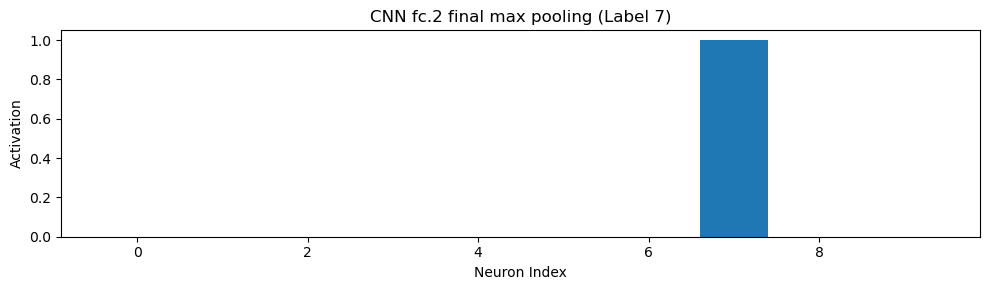

In [21]:
## Visualize the final class output

layer_name='fc.2'

# Get activations
feature_maps = jpt.get_feature_maps(cnn, img, layer_name=layer_name)

# Plot input + activations
jpt.plot_dense_activation(feature_maps, title=f"{cnn.name} {layer_name} final max pooling (Label {label})", softmax=True)

Bayesian model interpretability

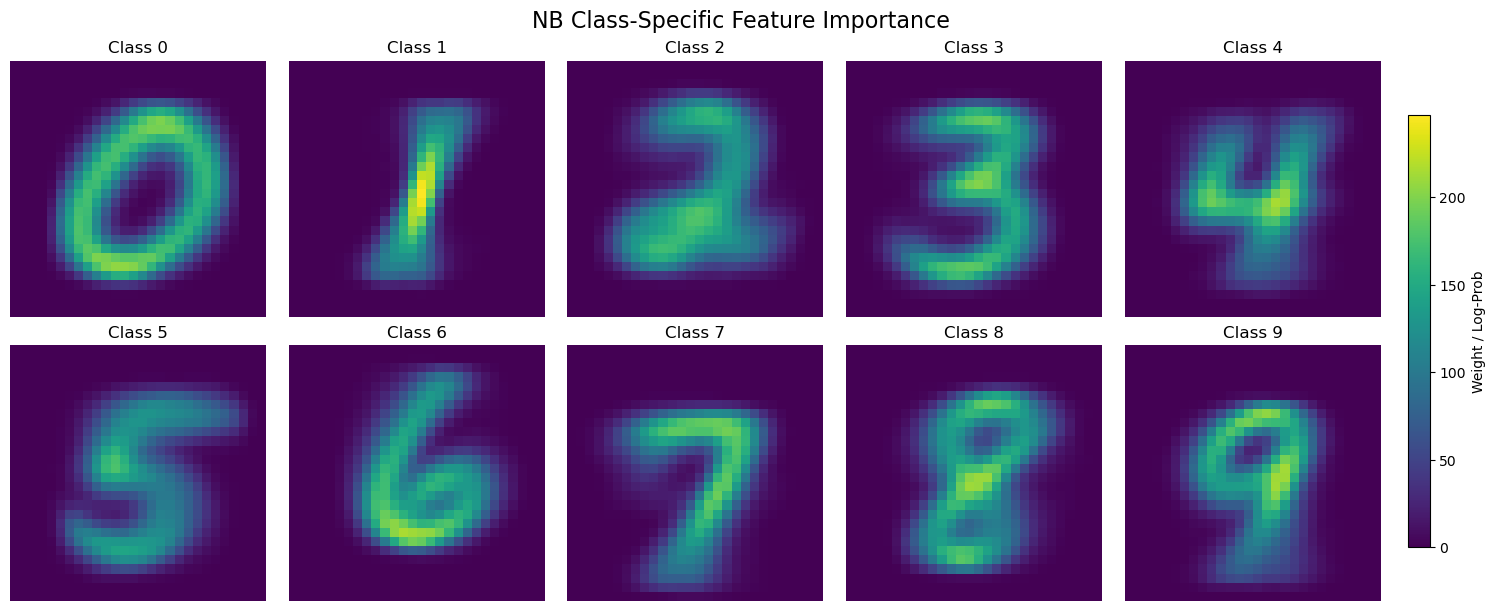

In [22]:
## Class by class feature importances for Naive Bayes Classifier.
nb = sklearn_models['NB'].model
jpt.plot_classwise_maps(nb, model_type="nb")